<a href="https://colab.research.google.com/github/gno-lit/DSI/blob/main/Great_Barrier_Reef/Preprocessing/Reef_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preprocessing is based on this [notebook](https://www.kaggle.com/julian3833/reef-starter-torch-fasterrcnn-train-lb-0-416/notebook) with edits 

**Files**

>**train/** - Folder containing training set photos of the form video_{video_id}/{video_frame_number}.jpg.

>**[train/test].csv** - Metadata for the images. As with other test files, most of the test metadata data is only available to your notebook upon submission. Just the first few rows available for download.

>>**video_id** - ID number of the video the image was part of. The video ids are not meaningfully ordered.
video_frame - The frame number of the image within the video. Expect to see occasional gaps in the frame number from when the diver surfaced.

>>**sequence** - ID of a gap-free subset of a given video. The sequence ids are not meaningfully ordered.
sequence_frame - The frame number within a given sequence.

>>**image_id** - ID code for the image, in the format '{video_id}-{video_frame}'

>>**annotations** - The bounding boxes of any starfish detections in a string format that can be evaluated directly with Python. Does not use the same format as the predictions you will submit. Not available in test.csv. A bounding box is described by the pixel coordinate (x_min, y_min) of its upper left corner within the image together with its width and height in pixels.

>**example_sample_submission.csv** - A sample submission file in the correct format. The actual sample submission will be provided by the API; this is only provided to illustrate how to properly format predictions. The submission format is further described on the Evaluation page.

>*example_test.npy* - Sample data that will be served by the example API.

>*greatbarrierreef* - The image delivery API that will serve the test set pixel arrays. You may need Python 3.7 and a Linux environment to run the example offline without errors.

Time-**series** API Details
The API serves the images one by one, in order by video and frame number, as pixel arrays.

Expect to see roughly 13,000 images in the test set.

The API will require roughly two GB of memory after initialization. The initialization step (env.iter_test()) will require meaningfully more memory than that; we recommend you do not load your model until after making that call. The API will also consume less than ten minutes of runtime for loading and serving the data.



In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!ls drive/MyDrive/GreatReef/tensorflow-great-barrier-reef

example_sample_submission.csv  greatbarrierreef  train.csv
example_test.npy	       test.csv		 train_images


In [3]:
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo                 
import albumentations as A                                                                            
from albumentations.pytorch import ToTensorV2
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-i2mls0s8



In [5]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BASE_DIR = "drive/MyDrive/GreatReef/tensorflow-great-barrier-reef/train_images/"

NUM_EPOCHS = 12

From the subsequences strategy for splitting, the train 0.1.csv is a train validation split of 10% gotten from the subsequence notebook [found here](https://www.kaggle.com/julian3833/reef-a-cv-strategy-subsequences/notebook#Generate-some-common-splits-based-on-subsequences)

The dataset is [here](https://www.kaggle.com/julian3833/reef-cv-strategy-subsequences-dataframes?select=cross-validation)


In [8]:
df = pd.read_csv("/content/drive/MyDrive/GreatReef/train-validation-split/train-0.1.csv")

# Turn annotations from strings into lists of dictionaries
df['annotations'] = df['annotations'].apply(eval)

# Create the image path for the row
df['image_path'] = "video_" + df['video_id'].astype(str) + "/" + df['video_frame'].astype(str) + ".jpg"

df.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,n_annotations,has_annotations,image_path,subsequence_id,is_train
0,0,40258,0,0,0-0,[],0,False,video_0/0.jpg,1,True
1,0,40258,1,1,0-1,[],0,False,video_0/1.jpg,1,True
2,0,40258,2,2,0-2,[],0,False,video_0/2.jpg,1,True
3,0,40258,3,3,0-3,[],0,False,video_0/3.jpg,1,True
4,0,40258,4,4,0-4,[],0,False,video_0/4.jpg,1,True


df[is_train] gives the subsequence id of dataframe preserving the class ratios  in both train and test dataset.
[More info here](https://www.kaggle.com/julian3833/reef-a-cv-strategy-subsequences/notebook#Generate-some-common-splits-based-on-subsequences)

In [9]:

df_train, df_val = df[df['is_train']], df[~df['is_train']]

Some models doesn't support images with no annotations and raises an error that suggest that it just doesn't support them.

Dropping those images;



In [10]:
df_train = df_train[df_train.annotations.str.len() > 0 ].reset_index(drop=True)
df_val = df_val[df_val.annotations.str.len() > 0 ].reset_index(drop=True)

In [11]:
# len(df_train[df_train['n_annotations'] > 0]) == len(df_train)
# df_train.shape[0], df_val.shape[0]

In [12]:
class ReefDataset:

    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def can_augment(self, boxes):
        """ Check if bounding boxes are OK to augment
        
        
        For example: image_id 1-490 has a bounding box that is partially outside of the image
        It breaks albumentation
        Here we check the margins are within the image to make sure the augmentation can be applied
        """
    
        box_outside_image = ((boxes[:, 0] < 0).any() or (boxes[:, 1] < 0).any() 
                             or (boxes[:, 2] > 1280).any() or (boxes[:, 3] > 720).any())
        return not box_outside_image

    def get_boxes(self, row):
        """Returns the bboxes for a given row as a 3D matrix with format [x_min, y_min, x_max, y_max]"""
        
        boxes = pd.DataFrame(row['annotations'], columns=['x', 'y', 'width', 'height']).astype(float).values
        
        # Change from [x_min, y_min, w, h] to [x_min, y_min, x_max, y_max]
        # boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        # boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return boxes
    
    def get_image(self, row):
        """Gets the image for a given row"""
        
        image = cv2.imread(f'{BASE_DIR}/{row["image_path"]}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        return image
    
    def __getitem__(self, i):

        row = self.df.iloc[i]
        image = self.get_image(row)
        boxes = self.get_boxes(row)
        
        n_boxes = boxes.shape[0]
        
        # Calculate the area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'area': torch.as_tensor(area, dtype=torch.float32),
            
            'image_id': torch.tensor([i]),
            
            # There is only one class
            'labels': torch.ones((n_boxes,), dtype=torch.int64),
            
            # Suppose all instances are not crowd
            'iscrowd': torch.zeros((n_boxes,), dtype=torch.int64)            
        }

        if self.transforms and self.can_augment(boxes):
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            if n_boxes > 0:
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        else:
            image = ToTensorV2(p=1.0)(image=image)['image']

        return image, target

    def __len__(self):
        return len(self.df)

In [13]:
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        #ToTensorV2(p=1.0),
        A.RandomSizedBBoxSafeCrop(width=448, height=336, erosion_rate=0.2)
    ], bbox_params=A.BboxParams(format = 'coco', label_fields= ['labels']))
#Determine min area and min visibility for better image augmentation

def get_valid_transform():
    return A.Compose([
        #ToTensorV2(p=1.0)
    ], bbox_params=A.BboxParams(format ='coco', label_fields = ['labels']))

In [14]:
# Define datasets
ds_train = ReefDataset(df_train, get_train_transform())
ds_val = ReefDataset(df_val, get_valid_transform())

In [15]:
# Let's get an interesting one ;)
df_train[df_train.annotations.str.len() > 12].head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,n_annotations,has_annotations,image_path,subsequence_id,is_train
2200,1,8503,4173,345,1-4173,"[{'x': 428, 'y': 156, 'width': 36, 'height': 2...",13,True,video_1/4173.jpg,80,True
2201,1,8503,4174,346,1-4174,"[{'x': 421, 'y': 156, 'width': 36, 'height': 2...",13,True,video_1/4174.jpg,80,True
2202,1,8503,4175,347,1-4175,"[{'x': 415, 'y': 157, 'width': 36, 'height': 2...",13,True,video_1/4175.jpg,80,True
2203,1,8503,4176,348,1-4176,"[{'x': 409, 'y': 157, 'width': 36, 'height': 2...",13,True,video_1/4176.jpg,80,True
2204,1,8503,4177,349,1-4177,"[{'x': 403, 'y': 157, 'width': 36, 'height': 2...",13,True,video_1/4177.jpg,80,True


In [16]:
image, targets = ds_train[2200]
image = torch.from_numpy(image)
image

tensor([[[0.2624, 0.5071, 0.6260],
         [0.2634, 0.5101, 0.6251],
         [0.2641, 0.5146, 0.6316],
         ...,
         [0.1827, 0.5936, 0.9178],
         [0.1812, 0.5968, 0.9184],
         [0.1856, 0.6087, 0.9269]],

        [[0.2664, 0.5111, 0.6300],
         [0.2753, 0.5200, 0.6389],
         [0.2711, 0.5158, 0.6347],
         ...,
         [0.1825, 0.5986, 0.9202],
         [0.1823, 0.5983, 0.9200],
         [0.1812, 0.6043, 0.9224]],

        [[0.2676, 0.5173, 0.6345],
         [0.2739, 0.5195, 0.6366],
         [0.2791, 0.5239, 0.6427],
         ...,
         [0.1847, 0.6008, 0.9224],
         [0.1847, 0.6008, 0.9224],
         [0.1831, 0.6006, 0.9215]],

        ...,

        [[0.6135, 0.9657, 0.8878],
         [0.4852, 0.7184, 0.6371],
         [0.4757, 0.6859, 0.6713],
         ...,
         [0.1860, 0.6647, 0.8797],
         [0.1912, 0.6193, 0.8052],
         [0.1842, 0.6568, 0.8325]],

        [[0.4554, 0.8000, 0.7559],
         [0.5118, 0.8212, 0.7363],
         [0.

In [17]:
#image
targets

{'area': tensor([ 50960., 171676., 107456., 177557.,  46656.,  52224., 208266.,  47311.,
         214020.,  70064.,  40920.,  58656., 311710.]),
 'boxes': tensor([[286.5882,  82.0282,  14.8235,  13.6714],
         [319.5294, 283.4178,  10.2941,  13.1456],
         [205.0588, 119.8873,  16.0588,  23.1362],
         [179.9412, 166.6854,  16.8824,  21.0329],
         [352.8823, 114.1033,  12.3529,  13.1455],
         [289.8824,  90.4413,  14.8235,  18.9296],
         [148.2353, 197.7089,  25.9412,  35.2300],
         [354.5294, 154.0657,  23.0588,  21.0329],
         [141.6471, 183.5117,  16.0588,  31.0235],
         [333.5294, 134.6103,   9.8824,  12.6197],
         [407.6471, 215.0610,  12.3529,  19.4554],
         [395.7059, 236.6197,  11.9412,  17.8779],
         [200.1176, 287.6244,  13.1765,  18.9296]], dtype=torch.float64),
 'image_id': tensor([2200]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


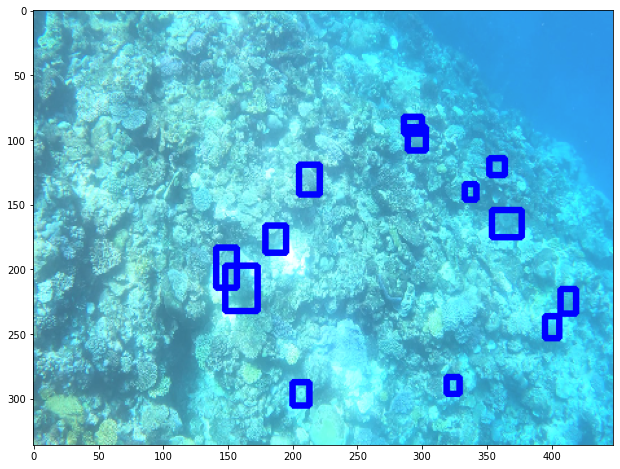

In [18]:
boxes = targets['boxes'].cpu().numpy().astype(np.int32)
# img = image.permute(1,2,0).cpu().numpy()
img = image.cpu().detach().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
#boxes
# getting x_max and y_max and using it to define the box;
# x_max = x_min + width
# y_max = y_min + height

for box in boxes:
   cv2.rectangle(img, (box[0], box[1]),(box[0]+box[2], 
                box[1] + box[3]),(0,0,255), 3)
    
# ax.set_axis_off()
ax.imshow(img);

In [19]:
def collate_fn(batch):
    return tuple(zip(*batch))

dl_train = DataLoader(ds_train, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)
dl_val = DataLoader(ds_val, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
